# Plotting seats and votes

If Party A gets 55% of the votes in an election, its natural to expect them to get 55% of the seats. This is the idea that election results should be _proportional_. The bad news is that our election system isn't particularly set up to promote proportionality. 

In this notebook, we're going to use data from the [The Daily Kos](https://docs.google.com/spreadsheets/d/1whYBonfwlgTGnYl7U_IH31G0JNYQ9QBIjDfqkZHkW-0/edit#gid=0) and [The MIT Election Data & Science Lab](https://electionlab.mit.edu) to look at how U.S. elections deviate from proportionality. 

In [9]:
# Here's where we set a threshold for the minimum number of districts a state has to have to be included in our plots.
# You can change it here to see how including states with small numbers of districts changes things.

min_number_of_districts = 6  

In [10]:
# Helper function to read in the Daily Kos data

%run utilities

import pandas as pd
import csv

def read_daily_kos_data(include_loser_bonus_states=True):
    year_to_row = {2016: 3, 2012: 5, 2008: 7}
    result_row = 2
        
    votes = []
    seats = []
    
    loser_bonus_state_count = 0

    for year in [2012, 2016]: # Full available list: [2008, 2012, 2016]
        presidential_dictionary = {}
        state_election_dictionary = {}

        with open('data/daily_kos.csv') as csv_file:
            csv_reader = csv.reader(csv_file, delimiter=',')
            line_count = 0
            for row in csv_reader:
                if line_count < 2:
                    pass
                else:
                    state_abbreviation = row[0]
                    split_string = state_abbreviation.split('-')
                    two_letter_state = split_string[0]

                    presidential_results = [float(row[year_to_row[year]]), float(row[year_to_row[year] + 1])]

                    result = row[result_row]
                    result_code = -1
                    if result == '(R)':
                        result_code = 0
                    if result == '(D)':
                        result_code = 1

                    if two_letter_state in state_election_dictionary:
                        state_election_dictionary[two_letter_state].append(result_code)
                    else:
                        state_election_dictionary[two_letter_state] = [result_code]

                    if two_letter_state in presidential_dictionary:
                        presidential_dictionary[two_letter_state].append(presidential_results)
                    else:
                        presidential_dictionary[two_letter_state] = [presidential_results]

                line_count += 1

        for key in presidential_dictionary.keys():
            all_presidential_results = presidential_dictionary[key]
            all_state_results = state_election_dictionary[key]

            republican_vote_share = 0
            for district in all_presidential_results:
                republican_vote_share = republican_vote_share + district[1]

            republican_vote_share = republican_vote_share / len(all_presidential_results)
            republican_vote_share = republican_vote_share / 100.0

            republican_seat_share = 0
            for district in all_state_results:
                if district == 0:
                    republican_seat_share = republican_seat_share + 1

            republican_seat_share = republican_seat_share / len(all_state_results)

            if len(all_state_results) >= min_number_of_districts:
                if (republican_vote_share < 0.5 and republican_seat_share < 0.5) or (1 - republican_vote_share < 0.5 and 1 - republican_seat_share < 0.5):
                    votes.append(republican_vote_share)
                    seats.append(republican_seat_share)
                    
                else:
                    if include_loser_bonus_states:
                        votes.append(republican_vote_share)
                        seats.append(republican_seat_share)
                        loser_bonus_state_count = loser_bonus_state_count + 1
    return votes, seats


## Plotting Congressional districts using Presidential vote share data

We're going to plot elections in the seats-votes plane, where vote shares are on the x-axis and seat shares are on the y-axis. The vote shares plotted are the average district vote share for Republicans.

On this plane, the line of proportionality is the line with slope 1 going through the point at (0.5, 0.5). Each point corresponds to a state and a year. Elections from 2012 and 2016 are plotted by default, though you can edit the function to include 2008. 

There's one big takeaway from the plot below. *U.S. elections don't typically fall on the line of proportionality*. In fact, the line of best fit has a slope closer to 3 than 1. 

Slope of regression line: 2.821902213304027
Intercept of regression line: -0.8438420207118194


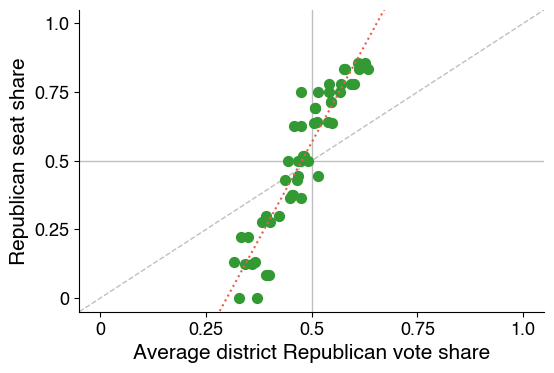

In [11]:
votes, seats = read_daily_kos_data()
plot_list_of_vote_and_seat_shares(votes, seats)

### Important caveat: Why use Presidential vote shares?

We glossed over something in the plot above. The average district vote shares come from the average vote shares for the Republican *Presidential* candidate, not the Congressional candidate. The `read_daily_kos_data` function reads in the Presidential vote share in each Congressional district, and uses those vote totals to predict if the district was won by a Democrat or a Republican. **This is sometimes wrong**: for example, if a Democrat won the Congressional district but the Republican Presidential candidate had a greater vote share, the district would be recorded and plotted as being won by a Republican.

So why use this data, even if it's not exactly right? The answer is uncontested districts, which mess with everything. An uncontested district's vote share for the party that doesn't run a candidate would be 0, even if there are people there who would have voted for a candidate from that party had they run. Using Presidential voting data helps us avoid this headache. 


## Winner's bonus, loser's bonus

People sometimes talk about the fact that elections fall on a line with slope greater than 1 in terms of "winner's bonuses"-- as in, when you win a majority of the vote share, you win _more than_ a proportional amount of the seat share. However, that papers over the fact that a good number of elections we've plotted actually have a _loser's bonus_: you get a bonus in seats despite the fact that you didn't win the majority of the votes. 

We can go quadrant by quadrant to understand what's going on for each election. 

- In the lower left quadrant, Republicans had a minority of the votes (by average district vote share), and a minority of the seats. 
- In the upper right quadrant, they had a average dis and a majority of the seats. 
- In the upper left quadrant, they had a minority of votes and a majority of the seats.
- In the lower right quadrant, they had a majority of the votes and a minority of the seats.

The plot below shows what happens if the upper left and lower right quadrants are excluded from the analysis.

Slope of regression line: 2.863107628196751
Intercept of regression line: -0.8752327421661712


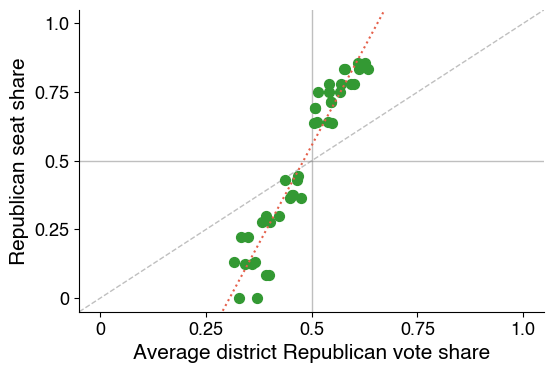

In [12]:
votes, seats = read_daily_kos_data(include_loser_bonus_states=False)
plot_list_of_vote_and_seat_shares(votes, seats)

## Plotting Congressional districts using actual US House vote shares

The plot of the Daily Kos data was a little dissatisfying, because it used Presidential vote shares in place of vote shares taken from actual US House elections. In the rest of this notebook, we're going to look at real US House election results, to show that we see roughly the same story, even though our pool of available states is smaller due to uncontested districts.


In [13]:
import pandas as pd
import numpy as np

historical_elections = pd.read_csv('data/1976-2018-house.csv', encoding = "ISO-8859-1")  # Load MIT Election Lab Data

def get_two_party_votes(state, year):
    in_state = historical_elections['state_po'] == state
    in_year = historical_elections["year"] == year

    results_in_state_and_year = historical_elections[in_state & in_year]
    
    in_republican_party = results_in_state_and_year['party'] == "republican"
    in_democratic_party = (results_in_state_and_year['party'] == "democrat") | (results_in_state_and_year['party'] == "democratic-farmer-labor")
    not_a_write_in = results_in_state_and_year['writein'] == False
    
    number_of_districts = np.amax(results_in_state_and_year['district'])
    
    district_offset = 1
    if number_of_districts == 0:
        number_of_districts = 1
        district_offset = 0

    republican_votes_by_district = []
    democrat_votes_by_district = []

    for i in range(number_of_districts):
        in_district = results_in_state_and_year['district'] == i + district_offset

        republican_in_district = results_in_state_and_year[in_district & in_republican_party & not_a_write_in]
        republican_candidates = republican_in_district['candidate'].values

        if len(republican_candidates) == 0:
            print('Warning! No Republican candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            republican_votes_by_district.append(0)
        else:
            # The next lines are to handle the way New York's data is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == republican_in_district['candidate'].values[0]
            republican_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = republican_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            republican_vote = np.sum(np.array(all_votes_for_candidate))
            republican_votes_by_district.append(republican_vote)

        democrat_in_district = results_in_state_and_year[in_district & in_democratic_party]
        democrat_candidates = democrat_in_district['candidate'].values

        if len(democrat_candidates) == 0:
            print('Warning! No Democrat candidate in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))
            democrat_votes_by_district.append(0)
        else:
            # The next lines are to handle the way New York's data is reported: 
            matches_candidate_name = results_in_state_and_year['candidate'] == democrat_in_district['candidate'].values[0]
            democrat_in_district = results_in_state_and_year[in_district & matches_candidate_name & not_a_write_in]
            all_votes_for_candidate_str = democrat_in_district['candidatevotes'].values
            all_votes_for_candidate = [int(vote) for vote in all_votes_for_candidate_str] 
            democrat_vote = np.sum(np.array(all_votes_for_candidate))
            democrat_votes_by_district.append(democrat_vote)

        if republican_votes_by_district[-1] == 0 and democrat_votes_by_district[-1] == 0:
            print('Warning! No votes registered in ' + state + ' District ' + str(i + 1) + ' in ' + str(year))

    return republican_votes_by_district, democrat_votes_by_district

    
# Get the fraction of votes each party got, when the race is reduced to just two parties. 
def votes_to_shares_by_district(party_a_votes, party_b_votes):
    
    party_a_vote_share = []
    party_b_vote_share = []
    
    for i in range(len(party_a_votes)):
        total_votes = party_a_votes[i] + party_b_votes[i]
        if total_votes != 0:
            party_a_vote_share.append(party_a_votes[i]/(total_votes))
            party_b_vote_share.append(party_b_votes[i]/(total_votes))
        else:
            print('Warning! No votes registered in a district. District was omitted.')

    return party_a_vote_share, party_b_vote_share


# Get the vote and seat shares for party A
def district_vote_shares_to_vote_and_seat_shares(vote_shares_by_district):
    
    # Note! This is the average district vote share, not the vote share in the state
    # They would agree if turnout everywhere were equal.
    vote_share = np.mean(vote_shares_by_district)  
    seats_won = 0
    seat_total = 0
    
    for vote_share_in_district in vote_shares_by_district:
        seat_total = seat_total + 1
        if vote_share_in_district > 0.5:
            seats_won = seats_won + 1
    
    seat_share = seats_won/seat_total
    return vote_share, seat_share



### Plotting a few elections

The code below plots vote shares and seat shares from US House Congressional elections from a list of states and prints a warning when the state has uncontested districts. You can edit the `states` list to change the states you plot. 

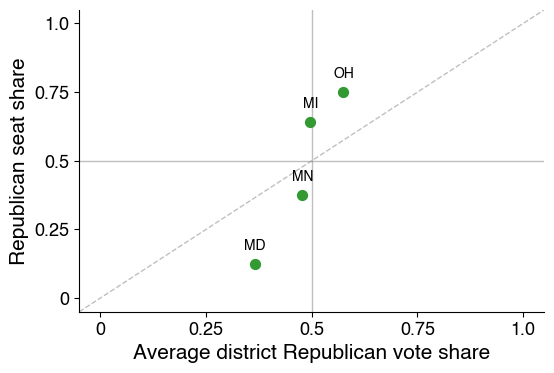

In [14]:
# Plot sample elections in the seats-votes plane

states = ["MD", "MN", "OH", "MI"]
year = 2016
vote_share_list = []
seat_share_list = []
point_label_list = []

for state in states:
    republican_votes_by_district, democrat_votes_by_district = get_two_party_votes(state, year) 
    republican_vote_share_by_district, democrat_vote_share_by_district = votes_to_shares_by_district(republican_votes_by_district, democrat_votes_by_district)
    vote_share, seat_share = district_vote_shares_to_vote_and_seat_shares(republican_vote_share_by_district)
    vote_share_list.append(vote_share)
    seat_share_list.append(seat_share)
    point_label_list.append(state)

plot_list_of_vote_and_seat_shares(vote_share_list,seat_share_list, regression=False, text='',point_labels=point_label_list)

## Plotting all the states without contested districts

The two cells below try to plot all fifty states using the actual vote share and seat share from US House Congressional elections. The cell below excludes states when they have an uncontested district, or too few districts (see `min_number_of_districts` at the top). The warnings are suppressed in this cell, but you can add them back in by removing the line `%%capture excluding`.

In [15]:
%%capture excluding  

# The above line suppresses the output of this cell; it's ugly

all_fifty_states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]

year = 2016
vote_share_list = []
seat_share_list = []
point_label_list = []

for state in all_fifty_states:
    republican_votes_by_district, democrat_votes_by_district = get_two_party_votes(state, year)
    republican_vote_share_by_district, democrat_vote_share_by_district = votes_to_shares_by_district(republican_votes_by_district, democrat_votes_by_district)

    if len(republican_votes_by_district) >= min_number_of_districts:
        uncontested_districts = len((np.where((np.array(republican_votes_by_district) == 0) | (np.array(democrat_votes_by_district) == 0))[0]).flatten())

        if uncontested_districts == 0:
            vote_share, seat_share = district_vote_shares_to_vote_and_seat_shares(republican_vote_share_by_district)
            vote_share_list.append(vote_share)
            seat_share_list.append(seat_share)
            point_label_list.append(state)
        else:
            print('Excluding ' + state + ' because of uncontested district')
    else: 
        print('Excluding ' + state + ' because it has too few districts')



Slope of regression line: 2.5401209827908238
Intercept of regression line: -0.7240334800191542


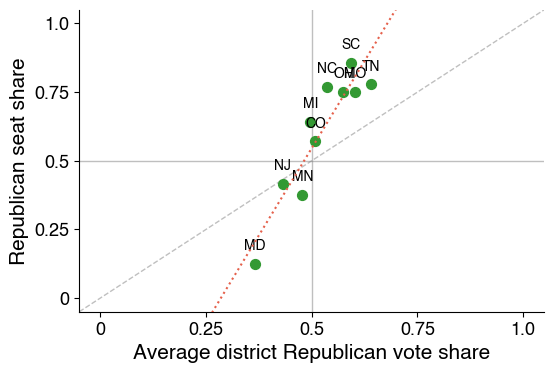

In [16]:
plot_list_of_vote_and_seat_shares(vote_share_list,seat_share_list, regression=True, text='',point_labels=point_label_list)

Once again, we see the slope is higher than one, although the pool of states we could use was much smaller thanks to the uncontested districts we encountered when using actual Congressional election results. 
